In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Installing the necessary libraries

In [2]:
!pip install tape-proteins
!pip install transformers
!pip install torch-geometric
!pip install pyTDC

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.9/68.9 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 67.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 10.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 99.7 MB/s eta 0:00:00

# Download the KIBA dataset

In [3]:
import os
os.mkdir('raw')

In [4]:
from tdc.multi_pred import DTI
import pandas as pd

data = DTI(name = 'KIBA')
# data.convert_to_log(form = 'binding')
split = data.get_split()

train_data, test_data = split['train'], split['test']
train_data['Prot_ID'] = train_data['Target_ID']
train_data['Protein'] = train_data['Target']
test_data['Prot_ID'] = test_data['Target_ID']
test_data['Protein'] = test_data['Target']
train_data = train_data.drop(['Target', 'Target_ID'], axis=1)
test_data = test_data.drop(['Target', 'Target_ID'], axis=1)
train_data.to_csv('./raw/DeepDTA_KIBA.tsv', sep="\t")
test_data.to_csv('./raw/DeepDTA_KIBA_test.tsv', sep="\t")

Downloading...
100%|██████████| 96.6M/96.6M [00:04<00:00, 21.8MiB/s]
Loading...
Done!


# importing libraries

In [5]:
import random
import torch
import numpy as np
import os.path as osp
from tqdm import tqdm
import pandas as pd
from torch_geometric.utils import from_smiles
from torch.utils.data import Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset as GraphDataset, Data
from tape import ProteinBertModel, TAPETokenizer
from transformers import AutoModel, AutoTokenizer

# Utility functions for preprocessing of data

In [6]:
# util functions
        
#train validation test split from the dataframe
def split_data(data_splits, data):
    # print(data)
    drugs = list(data['Drug_ID'].unique())
    n_drug = len(drugs)
    n = len(data)
    n_train = int(round(n * data_splits[0]))
    n_valid = int(round(n * data_splits[1]))
    # n_test = int(round(n * data_splits[2]))
    ids = np.arange(n, dtype=int)
    random.shuffle(ids)
    train = {'ids': ids[:n_train]}
    train['drugs'] = data.loc[train['ids'], 'Drug_ID'].unique()
    valid = {'ids': ids[n_train:n_train+n_valid]}
    valid['drugs'] = data.loc[valid['ids'], 'Drug_ID'].unique()
    test = {'ids': ids[n_train+n_valid:]}
    test['drugs'] = data.loc[test['ids'], 'Drug_ID'].unique()
    return train, valid, n_drug

In [7]:
def get_node_edges(smiles_edges, index_map):
    node_edges = [[], []]
    for edge in smiles_edges.T:

        id_0 = np.logical_and(index_map['smiles_i0'] <= edge[0],
                              index_map['smiles_i1'] >= edge[0])
        id_1 = np.logical_and(index_map['smiles_i0'] <= edge[1],
                              index_map['smiles_i1'] >= edge[1])
        if id_0.sum() == 1 and id_1.sum() == 1:
            node_edges[0].append(int(index_map[id_0]['token_i']))
            node_edges[1].append(int(index_map[id_1]['token_i']))
        elif id_0.sum() > 1 or id_1.sum() > 1:
            raise ValueError('The edge seems to connect to multiple nodes!')

    return np.array(node_edges, dtype=int)


def smiles_edges_to_token_edges(smiles, tokenizer, reverse_vocab):
    token_ids = tokenizer.encode(smiles)
    index_map = get_indexmap(token_ids, reverse_vocab, smiles)
    smiles_edges = from_smiles(smiles).edge_index
    node_edges = get_node_edges(smiles_edges, index_map)
    # keep only between node edges
    node_edges = node_edges[:, ((node_edges[0] - node_edges[1]) != 0)]
    # remove duplicates. Duplicates can occur when different atoms within the
    # same nodes are connected to each other.
    node_edges = np.unique(node_edges, axis=1)
    return node_edges, index_map


def get_indexmap(token_ids, rev_vocab, smiles):
    index_map = pd.DataFrame(index=range(len(token_ids)),columns=['token_i','token','token_id','keep','smiles_i0','smiles_i1'])
    start = 0
    token_i = 0
    for i, token_id in enumerate(token_ids):

        token = rev_vocab[token_id]

        if token.isalpha():  # only all alphabetic chars are nodes
            smiles_i0 = smiles[start:].find(token)
            if smiles_i0 >= 0:
                smiles_i0 += start
                smiles_i1 = smiles_i0 + len(token)
                start = smiles_i1

                index_map.loc[i] = (token_i, token, token_id,
                                    True, smiles_i0, smiles_i1 - 1)
                token_i += 1
            else:
                raise ValueError('Node token not found in SMILES.\nCheck that '
                                 'token_ids are computed from smiles.')
        else:
            index_map.loc[i] = (-1, token, token_id, False, -1, -1)

    return index_map


def edges_from_protein_sequence(prot_seq):
    n = len(prot_seq)
    # first and row in COO format
    # each node is connected to left and right except the first an last.
    edge_index = np.stack([np.repeat(np.arange(n), 2)[1:-1],
                           np.repeat(np.arange(n), 2)[1:-1]], axis=0)
    for i in range(0, len(edge_index[0]), 2):
        edge_index[1, i], edge_index[1, i+1] = edge_index[1, i+1], edge_index[1, i]

    return torch.tensor(edge_index, dtype=torch.long)


## Preprocessing the dataset by converting the sequences and SMILES to their graph node embeddings

In [8]:
class Dataset(GraphDataset):
    def __init__(self, root):
        self.partition = 'train'
        self.partition_kind = 'pair'
        self.dataset_name = 'KIBA'
        self.raw_file_name = f'DeepDTA_KIBA.tsv'
        self.data_splits = (1.0, 0.0, 0.)
        self.drug_encoder_name = 'DeepChem/ChemBERTa-77M-MTR'
        self.prot_encoder_name = 'bert-base'
        self.drug_encoder = AutoModel.from_pretrained(self.drug_encoder_name)
        self.drug_tokenizer = AutoTokenizer.from_pretrained(self.drug_encoder_name)
        self.prot_encoder = ProteinBertModel.from_pretrained(self.prot_encoder_name)
        self.prot_tokenizer = TAPETokenizer(vocab='iupac')

        # 384 for drug features embedding
        # 786 for protein features embedding
        self.num_drug_features = self.drug_encoder.config.hidden_size
        self.num_prot_features = self.prot_encoder.config.hidden_size

        super(Dataset, self).__init__(root, None, None)

        # Split data into train/valid/test sets
        train, valid, n_drug = split_data(self.data_splits,self.raw_data)
        self.n_drug = n_drug
        self.train_ids, self.train_drugs = train['ids'], train['drugs']
        self.valid_ids, self.valid_drugs = valid['ids'], valid['drugs']
#         self.test_ids, self.test_drugs = test['ids'], test['drugs']

    @property
    def raw_file_names(self):
        return self.raw_file_name

    @property
    def processed_file_names(self):
        self.raw_data = pd.read_csv(osp.join(self.raw_dir, self.raw_file_name),
                                    sep='\t')
        self.prots = self.raw_data['Prot_ID'].unique()
        self.drugs = self.raw_data['Drug_ID'].unique()
        self.n_prot, self.n_drug = len(self.prots), len(self.drugs)
        self.n_total = self.n_prot + self.n_drug
        prot_embed_fnames = [self._build_embed_fname(id) for id in self.prots]
        drug_embed_fnames = [self._build_embed_fname(id) for id in self.drugs]

        return prot_embed_fnames + drug_embed_fnames

    def download(self):
        pass

    def _build_embed_fname(self, ID):
        return f'{self.dataset_name}_{ID}_embedded.pt'

    def process(self):

        vocab = self.drug_tokenizer.vocab
        reverse_vocab = {key: val for val, key in vocab.items()}
        self.prot_encoder.to('cuda')
        self.drug_encoder.to('cuda')
        processed_prots, processed_drugs = [], []
        for idx, row in tqdm(self.raw_data.iterrows(), total=self.n_total):
            with torch.no_grad():
                # Only embed a protein if it hasn't already been embedded and saved
                if row["Prot_ID"] not in processed_prots:
                    tokens = torch.tensor(self.prot_tokenizer.encode(row['Protein'])).to('cuda')
                    embed = self.prot_encoder(tokens.reshape(1, -1))[0].squeeze()
                    embed = embed.to('cpu')
                    edges = edges_from_protein_sequence(row['Protein'])
                    data = {'embeddings': Data(x=embed[1:-1], edge_index=edges),'Prot_ID': row['Prot_ID']}
                    fname = self._build_embed_fname(row["Prot_ID"])
                    torch.save(data, osp.join(self.processed_dir, fname))
                    processed_prots.append(row['Prot_ID'])

              # Only embed a drug if it hasn't already been embedded and saved
                if row['Drug_ID'] not in processed_drugs:
                    tokens = torch.tensor(self.drug_tokenizer.encode(row['Drug'],truncation=True, max_length=512)).to('cuda')
                    embed = self.drug_encoder(tokens.reshape(1, -1)).last_hidden_state
                    embed = embed.to('cpu')
                    edges, index_map = smiles_edges_to_token_edges(row['Drug'],self.drug_tokenizer,reverse_vocab)
                    data = {'embeddings':
                          Data(x=embed.squeeze(),
                                edge_index=torch.tensor(edges, dtype=torch.long)),
                          'Drug_ID': row['Drug_ID'],
                          'node_ids': index_map['keep'].values.astype('bool')}
                    fname = self._build_embed_fname(row["Drug_ID"])
                    torch.save(data, osp.join(self.processed_dir, fname))
                    processed_drugs.append(row['Drug_ID'])

    def len(self):

        if self.partition == 'train':
            n = len(self.train_ids)
        elif self.partition == 'valid':
            n = len(self.valid_ids)
        elif self.partition == 'test':
            n = len(self.test_ids)
        else:
            n = len(self.raw_data.index)

        return n

    def get(self, idx):

        if self.partition == 'train':
            row = self.raw_data.loc[self.train_ids[idx]]
        elif self.partition == 'valid':
            row = self.raw_data.loc[self.valid_ids[idx]]
        elif self.partition == 'test':
            row = self.raw_data.loc[self.test_ids[idx]]
        else:
            row = self.raw_data.loc[self.raw_data.index[idx]]

        prot_embed_fname = osp.join(self.processed_dir,
                                    self._build_embed_fname(row["Prot_ID"]))
        prot_data = torch.load(prot_embed_fname)

        drug_embed_fname = osp.join(self.processed_dir,
                                    self._build_embed_fname(row["Drug_ID"]))
        drug_data = torch.load(drug_embed_fname)

        
        
        y = torch.tensor([row['Y']], dtype=torch.float32)

        meta = {'Drug_ID': str(drug_data['Drug_ID']),
                'Prot_ID': str(prot_data['Prot_ID']),
                'raw_Drug_ID': str(row['Drug_ID']),
                'Drug': row['Drug'],
                'raw_Prot_ID': str(row['Prot_ID']),
                'Prot': row['Protein'],
                'Y': row['Y']}

        drug_data['embeddings'].x.requires_grad = False
        prot_data['embeddings'].x.requires_grad = False

        return drug_data['embeddings'], prot_data['embeddings'], y, meta


In [ ]:
dataset = Dataset(root=".")

Some weights of the model checkpoint at DeepChem/ChemBERTa-77M-MTR were not used when initializing RobertaModel: ['regression.dense.weight', 'regression.out_proj.bias', 'norm_mean', 'norm_std', 'regression.dense.bias', 'regression.out_proj.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


100%|██████████| 370264230/370264230 [00:06<00:00, 58483799.41B/s]
Processing...
79685it [05:51,  8.21it/s]                          Token indices sequence length is longer than the specified maximum sequence length for this model (534 > 512). Running this sequence through the model will result in indexing errors
82360it [07:04, 194.17it/s]
Done!


# Our Model which uses GCN and BERT

In [ ]:
import torch
from torch_geometric.nn import Linear as GraphLinear
from torch_geometric.nn import global_mean_pool, BatchNorm
from torch_geometric.nn import GCNConv, DeepGCNLayer
from torch.nn import Embedding, Conv1d, Conv2d, Linear, Dropout, ReLU
from torch.nn import AdaptiveMaxPool1d, AdaptiveMaxPool2d, LayerNorm

class GCNBert(torch.nn.Module):

    def __init__(self, dataset, n_hidden=128):
        super(GCNBert, self).__init__()
        self.batchnorm_d = BatchNorm(dataset.num_drug_features)
        self.dense_d1 = GraphLinear(dataset.num_drug_features, 2*n_hidden)
        self.dense_d2 = GraphLinear(2*n_hidden, n_hidden)
        self.gconv_d1 = GCNConv(n_hidden, n_hidden)
        self.gconv_d2 = GCNConv(n_hidden, n_hidden)
        self.gconv_d3 = GCNConv(n_hidden, n_hidden)
        self.gconv_d4 = GCNConv(n_hidden, n_hidden)
        
        self.batchnorm_p = BatchNorm(dataset.num_prot_features)
        self.dense_p1 = GraphLinear(dataset.num_prot_features, 2*n_hidden)
        self.dense_p2 = GraphLinear(2*n_hidden, n_hidden)
        self.gconv_p1 = GCNConv(n_hidden, n_hidden)
        self.gconv_p2 = GCNConv(n_hidden, n_hidden)
        self.gconv_p3 = GCNConv(n_hidden, n_hidden)
        self.gconv_p4 = GCNConv(n_hidden, n_hidden)

        self.dense_1 = GraphLinear(2*n_hidden, 512)
        self.dense_2 = GraphLinear(512, 256)
        self.dense_3 = GraphLinear(256, 128)
        self.dense_4 = Linear(256, 1)

    def forward(self, xd, xp):
        xd.x = self.batchnorm_d(xd.x)
        xd.x = self.dense_d1(xd.x).relu()
        xd.x = self.dense_d2(xd.x).relu()
        xd.x = self.gconv_d1(xd.x, xd.edge_index).relu()
        xd.x = self.gconv_d2(xd.x, xd.edge_index).relu()
        xd.x = self.gconv_d3(xd.x, xd.edge_index).relu()
        xd.x = self.gconv_d4(xd.x, xd.edge_index).relu()
        xd.x = global_mean_pool(xd.x, xd.batch)

        xp.x = self.batchnorm_p(xp.x)
        xp.x = self.dense_p1(xp.x).relu()
        xp.x = self.dense_p2(xp.x).relu()
        xp.x = self.gconv_p1(xp.x, xp.edge_index).relu()
        xp.x = self.gconv_p2(xp.x, xp.edge_index).relu()
        xp.x = self.gconv_p3(xp.x, xp.edge_index).relu()
        xp.x = self.gconv_p4(xp.x, xp.edge_index).relu()
        xp.x = global_mean_pool(xp.x, xp.batch) 
        
        x = torch.cat([xd.x, xp.x], dim=1)
        x = self.dense_1(x).relu()
        x = self.dense_2(x).relu()
        pred = self.dense_4(x)
        return pred

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = GCNBert(dataset).to(device)

## we kept the batch size to 256 and optimizer as Adam with learning rate as 0.001

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()

# train and evaluate function

In [ ]:
import sys
import tqdm
def train(data_loader, model, device, loss_fn, optimizer, verbose=False):

    model.train()
    data_loader.dataset.partition = 'train'
    ave_loss = 0.0
    
    num_batch = len(data_loader)
    # Iterate in batches over the training dataset.
    # for batch, data in enumerate(dataloader):
    for batch, data in enumerate(data_loader):
        xd, xp = data[0].to(device), data[1].to(device)
        # Forward
        pred = model(xd, xp)
        # Compute the lossSS
        loss = loss_fn(pred, data[2].to(device, dtype=torch.float32))
        # Backpropagation
        loss.backward()
        # Weight update
        optimizer.step()
        optimizer.zero_grad()

        batch_loss = loss.detach().item()
        ave_loss += batch_loss
        if verbose:
            s = f'{batch_loss:.3f}'
            print('Batch loss: '+s, end='\r')
            sys.stdout.flush()

    if verbose:
        print()

    return ave_loss / num_batch


def evaluate(data_loader, model, device, loss_fn, partition='valid'):

    data_loader.dataset.partition = 'train'
    batch_size = data_loader.batch_size
    model.eval()
    num_batch = len(data_loader)
    ave_loss = 0.0
    preds = np.empty(batch_size * num_batch)
    targets = np.empty(batch_size * num_batch)

    with torch.no_grad():
        # Iterate in batches over the validation dataset.
        for batch, data in enumerate(data_loader):
            y = data[2].to(device, dtype=torch.float32)
            pred = model(data[0].to(device), data[1].to(device))
            ave_loss += loss_fn(pred, y).item()
            pred = pred.cpu().detach().numpy().flatten()
            i0, i1 = batch * batch_size, batch * batch_size + pred.shape[0]
            preds[i0: i1] = pred
            targets[i0: i1] = y.cpu().detach().numpy().flatten()

    return preds, targets, ave_loss / num_batch

# 5-fold Cross Validation (as implemented in the DeepDTA's paper)

In [ ]:
fraction = 0.2
k_fold = 5
train_score = pd.Series()
val_score = pd.Series()

total_size = len(dataset)
fraction = 1/k_fold
seg = int(total_size * fraction)

In [ ]:

# tr:train,val:valid; r:right,l:left;  eg: trrr: right index of right side train subset 
# index: [trll,trlr],[vall,valr],[trrl,trrr]
def fold():
    for i in range(k_fold):
        trll = 0
        trlr = i * seg
        vall = trlr
        valr = i * seg + seg
        trrl = valr
        trrr = total_size

        train_left_indices = list(range(trll,trlr))
        train_right_indices = list(range(trrl,trrr))

        train_indices = train_left_indices + train_right_indices
        val_indices = list(range(vall,valr))

        train_set = torch.utils.data.dataset.Subset(dataset,train_indices)
        val_set = torch.utils.data.dataset.Subset(dataset,val_indices)

        train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
        val_loader = DataLoader(val_set, batch_size=256, shuffle=True)
        train_loss = train(train_loader, model, device,loss_fn, optimizer, verbose=True)
        train_score.at[i] = train_loss
        pred_valid, y_valid, valid_loss = evaluate(val_loader, model, device,loss_fn, partition='valid')
        val_score.at[i] = valid_loss
        print(f'-- train MSE: {train_loss:.4f}', f', valid MSE: {valid_loss:.4f}')
    

# Training and fine tuning the model

In [ ]:
for epoch in range(6,51):
    print(f"Epoch: {epoch}")
    fold()
    state = {
        'epoch': epoch+1,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    torch.save(state, f"./model{epoch}.t7")

Epoch: 6
Batch loss: 0.296
-- train MSE: 0.3833 , valid MSE: 0.4105
Batch loss: 0.478
-- train MSE: 0.3747 , valid MSE: 0.3642
Batch loss: 0.352
-- train MSE: 0.3769 , valid MSE: 0.4354
Batch loss: 0.231
-- train MSE: 0.3720 , valid MSE: 0.4513
Batch loss: 0.255
-- train MSE: 0.3681 , valid MSE: 0.3857
Epoch: 7
Batch loss: 0.276
-- train MSE: 0.3564 , valid MSE: 0.3399
Batch loss: 0.367
-- train MSE: 0.3382 , valid MSE: 0.3175
Batch loss: 0.288
-- train MSE: 0.3359 , valid MSE: 0.4180
Batch loss: 0.473
-- train MSE: 0.3196 , valid MSE: 0.3119
Batch loss: 0.282
-- train MSE: 0.3244 , valid MSE: 0.2929
Epoch: 8
Batch loss: 0.276
-- train MSE: 0.3056 , valid MSE: 0.3017
Batch loss: 0.276
-- train MSE: 0.3081 , valid MSE: 0.3008
Batch loss: 0.598
-- train MSE: 0.3052 , valid MSE: 0.2907
Batch loss: 0.364
-- train MSE: 0.2983 , valid MSE: 0.2910
Batch loss: 0.343
-- train MSE: 0.2938 , valid MSE: 0.2844
Epoch: 9
Batch loss: 0.238
-- train MSE: 0.2894 , valid MSE: 0.2817
Batch loss: 0.272
--

KeyboardInterrupt: 

# Plotting of train and valid MSE

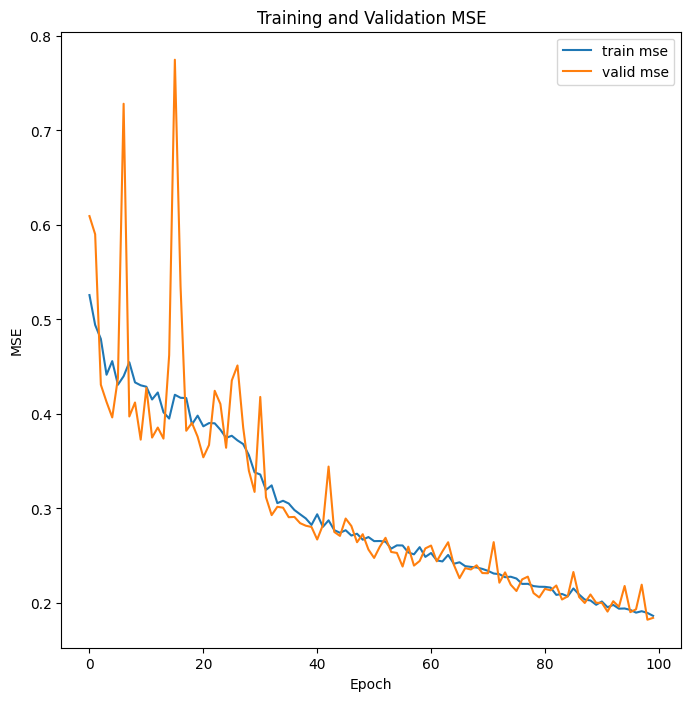

In [ ]:
import matplotlib.pyplot as plt
# this data, i have copied it from the log which you can see above as i forgot to save it in history
arr = [0.5258 ,0.6094,0.4942 ,0.5902,0.4794 ,0.4309,0.4415 ,0.4127,0.4559 ,0.3963,0.4309 ,0.4379,0.4399 ,0.7283,0.4547 ,0.3973,0.4334 ,0.4121,0.4303 ,0.3728,0.4288 ,0.4276,0.4153 ,0.3750,0.4227 ,0.3856,0.4018 ,0.3739,0.3951 ,0.4623,0.4203 ,0.7749,0.4171 ,0.5350,0.4168 ,0.3822,0.3889 ,0.3905,0.3982 ,0.3759,0.3869 ,0.3541,0.3903 ,0.3671,0.3901 ,0.4245,0.3833 ,0.4105,0.3747 ,0.3642,0.3769 ,0.4354,0.3720 ,0.4513,0.3681 ,0.3857,0.3564 ,0.3399,0.3382 ,0.3175,0.3359 ,0.4180,0.3196 ,0.3119,0.3244 ,0.2929,0.3056 ,0.3017,0.3081 ,0.3008,0.3052 ,0.2907,0.2983 ,0.2910,0.2938 ,0.2844,0.2894 ,0.2817,0.2825 ,0.2804,0.2938 ,0.2671,0.2805 ,0.2824,0.2874 ,0.3443,0.2770 ,0.2751,0.2742 ,0.2709,0.2769 ,0.2893,0.2713 ,0.2814,0.2732 ,0.2642,0.2669 ,0.2727,0.2697 ,0.2565,0.2654 ,0.2476,0.2655 ,0.2595,0.2648 ,0.2689,0.2574 ,0.2539,0.2609 ,0.2529,0.2608 ,0.2385,0.2534 ,0.2595,0.2514 ,0.2395,0.2590 ,0.2444,0.2487 ,0.2577,0.2528 ,0.2607,0.2450 ,0.2440,0.2439 ,0.2545,0.2508 ,0.2642,0.2414 ,0.2404,0.2430 ,0.2262,0.2389 ,0.2368,0.2381 ,0.2354,0.2375 ,0.2398,0.2360 ,0.2316,0.2339 ,0.2314,0.2311 ,0.2643,0.2304 ,0.2214,0.2272 ,0.2323,0.2277 ,0.2192,0.2258 ,0.2126,0.2201 ,0.2249,0.2202 ,0.2278,0.2178 ,0.2104,0.2171 ,0.2058,0.2170 ,0.2149,0.2162 ,0.2133,0.2085 ,0.2184,0.2095 ,0.2036,0.2069 ,0.2069,0.2153 ,0.2327,0.2089 ,0.2063,0.2035 ,0.1999,0.2026 ,0.2089,0.1980 ,0.2001,0.2015 ,0.2001,0.1954 ,0.1908,0.1979 ,0.2018,0.1939 ,0.1959,0.1941 ,0.2179,0.1926 ,0.1902,0.1897 ,0.1932,0.1912 ,0.2193,0.1894 ,0.1822,0.1863 ,0.1842]
train_mse = [arr[i] for i in range(0, len(arr), 2)]
valid_mse = [arr[i] for i in range(1, len(arr), 2)]

x = list(range(len(train_mse)))

plt.figure(figsize=(8, 8))
plt.title("Training and Validation MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.plot(x, train_mse, label="train mse")
plt.plot(x, valid_mse, label="valid mse")
plt.legend()
plt.show()


In [ ]:
class TestDataset(GraphDataset):
    def __init__(self, root):
        self.partition = 'train'
        self.partition_kind = 'pair'
        self.dataset_name = 'KIBA'
        self.raw_file_name = f'DeepDTA_KIBA_test.tsv'
        self.data_splits = (1.0, 0., 0.)
        self.drug_encoder_name = 'DeepChem/ChemBERTa-77M-MTR'
        self.prot_encoder_name = 'bert-base'
        self.drug_encoder = AutoModel.from_pretrained(self.drug_encoder_name)
        self.drug_tokenizer = AutoTokenizer.from_pretrained(self.drug_encoder_name)
        self.prot_encoder = ProteinBertModel.from_pretrained(self.prot_encoder_name)
        self.prot_tokenizer = TAPETokenizer(vocab='iupac')

        # 384 for drug features embedding
        # 786 for protein features embedding
        self.num_drug_features = self.drug_encoder.config.hidden_size
        self.num_prot_features = self.prot_encoder.config.hidden_size

        super(TestDataset, self).__init__(root, None, None)

        # Split data into train/valid/test sets
        train, valid, n_drug = split_data(self.data_splits,self.raw_data)
        self.n_drug = n_drug
        self.train_ids, self.train_drugs = train['ids'], train['drugs']
        self.valid_ids, self.valid_drugs = valid['ids'], valid['drugs']
#         self.test_ids, self.test_drugs = test['ids'], test['drugs']

    @property
    def raw_file_names(self):
        return self.raw_file_name

    @property
    def processed_file_names(self):
        self.raw_data = pd.read_csv(osp.join(self.raw_dir, self.raw_file_name),
                                    sep='\t')
        self.prots = self.raw_data['Prot_ID'].unique()
        self.drugs = self.raw_data['Drug_ID'].unique()
        self.n_prot, self.n_drug = len(self.prots), len(self.drugs)
        self.n_total = self.n_prot + self.n_drug
        prot_embed_fnames = [self._build_embed_fname(id) for id in self.prots]
        drug_embed_fnames = [self._build_embed_fname(id) for id in self.drugs]

        return prot_embed_fnames + drug_embed_fnames

    def download(self):
        pass

    def _build_embed_fname(self, ID):
        return f'{self.dataset_name}_{ID}_embedded.pt'

    def process(self):

        vocab = self.drug_tokenizer.vocab
        reverse_vocab = {key: val for val, key in vocab.items()}
        self.prot_encoder.to('cuda')
        self.drug_encoder.to('cuda')
        processed_prots, processed_drugs = [], []
        for idx, row in tqdm(self.raw_data.iterrows(), total=self.n_total):
            with torch.no_grad():
                # Only embed a protein if it hasn't already been embedded and saved
                if row["Prot_ID"] not in processed_prots:
                    tokens = torch.tensor(self.prot_tokenizer.encode(row['Protein'])).to('cuda')
                    embed = self.prot_encoder(tokens.reshape(1, -1))[0].squeeze()
                    embed = embed.to('cpu')
                    edges = edges_from_protein_sequence(row['Protein'])
                    data = {'embeddings': Data(x=embed[1:-1], edge_index=edges),'Prot_ID': row['Prot_ID']}
                    fname = self._build_embed_fname(row["Prot_ID"])
                    torch.save(data, osp.join(self.processed_dir, fname))
                    processed_prots.append(row['Prot_ID'])

              # Only embed a drug if it hasn't already been embedded and saved
                if row['Drug_ID'] not in processed_drugs:
                    tokens = torch.tensor(self.drug_tokenizer.encode(row['Drug'],truncation=True, max_length=512)).to('cuda')
                    embed = self.drug_encoder(tokens.reshape(1, -1)).last_hidden_state
                    embed = embed.to('cpu')
                    edges, index_map = smiles_edges_to_token_edges(row['Drug'],self.drug_tokenizer,reverse_vocab)
                    data = {'embeddings':
                          Data(x=embed.squeeze(),
                                edge_index=torch.tensor(edges, dtype=torch.long)),
                          'Drug_ID': row['Drug_ID'],
                          'node_ids': index_map['keep'].values.astype('bool')}
                    fname = self._build_embed_fname(row["Drug_ID"])
                    torch.save(data, osp.join(self.processed_dir, fname))
                    processed_drugs.append(row['Drug_ID'])

    def len(self):

        if self.partition == 'train':
            n = len(self.train_ids)
        elif self.partition == 'valid':
            n = len(self.valid_ids)
        elif self.partition == 'test':
            n = len(self.test_ids)
        else:
            n = len(self.raw_data.index)

        return n

    def get(self, idx):

        if self.partition == 'train':
            row = self.raw_data.loc[self.train_ids[idx]]
        elif self.partition == 'valid':
            row = self.raw_data.loc[self.valid_ids[idx]]
        elif self.partition == 'test':
            row = self.raw_data.loc[self.test_ids[idx]]
        else:
            row = self.raw_data.loc[self.raw_data.index[idx]]

        prot_embed_fname = osp.join(self.processed_dir,
                                    self._build_embed_fname(row["Prot_ID"]))
        prot_data = torch.load(prot_embed_fname)

        drug_embed_fname = osp.join(self.processed_dir,
                                    self._build_embed_fname(row["Drug_ID"]))
        drug_data = torch.load(drug_embed_fname)

        
        
        y = torch.tensor([row['Y']], dtype=torch.float32)

        meta = {'Drug_ID': str(drug_data['Drug_ID']),
                'Prot_ID': str(prot_data['Prot_ID']),
                'raw_Drug_ID': str(row['Drug_ID']),
                'Drug': row['Drug'],
                'raw_Prot_ID': str(row['Prot_ID']),
                'Prot': row['Protein'],
                'Y': row['Y']}

        drug_data['embeddings'].x.requires_grad = False
        prot_data['embeddings'].x.requires_grad = False

        return drug_data['embeddings'], prot_data['embeddings'], y, meta



In [ ]:
test_dataset = TestDataset(root=".")


Some weights of the model checkpoint at DeepChem/ChemBERTa-77M-MTR were not used when initializing RobertaModel: ['regression.dense.weight', 'regression.out_proj.bias', 'norm_mean', 'norm_std', 'regression.dense.bias', 'regression.out_proj.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
data_loader = DataLoader(dataset, batch_size=256, shuffle=True)
pred_test, y_test, test_loss = evaluate(data_loader, model, device,loss_fn, partition='train')
print(test_loss)

0.18125165327217266


In [ ]:
from tqdm import tqdm
def concordance_index(y_test, pred_test):
    CI = 0
    n = len(y_test)
    for i in range(n):
        for j in range(i + 1, n):
            lo = i
            hi = j
            if y_test[i] > y_test[j]:
                lo, hi = hi, lo
            val = pred_test[hi] - pred_test[lo]
            if val > 0 :
                CI += 1
            elif val == 0 :
                CI += 0.5
    CI /= n*(n-1)/2
    return CI


In [ ]:
ci_test = concordance_index(y_test, pred_test)
print(ci_test)

0.8712244532794694
